In [1]:
import pandas as pd
import itertools
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import helpers as hp
import model.queries as qrs

sns.set_theme(style="whitegrid")



### Check packet loss measures to the problematic site INFN-ROMA1

In [2]:
site = 'INFN-ROMA1'

dt = hp.GetTimeRanges('2021-01-21 07:00','2021-02-01 07:00')
pl = qrs.getMeasures(dt, 'dest_site', site, 'ps_packetloss')

pl.head()

,packet_loss,src,dest_site,ipv6,dest_host,src_host,dest,src_site,timestamp,dt
0,0.000000,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649286000,2021-01-26 08:21:26
1,0.000000,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649346000,2021-01-26 08:22:26
2,0.000000,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649357000,2021-01-26 08:22:37
3,0.000000,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649587000,2021-01-26 08:26:27
4,0.001667,2001:948:40:3::86,INFN-ROMA1,True,perfsonar2.roma1.infn.it,perfsonar-ps.ndgf.org,2001:760:422c:35::18,NDGF-T1,1611594904000,2021-01-25 17:15:04


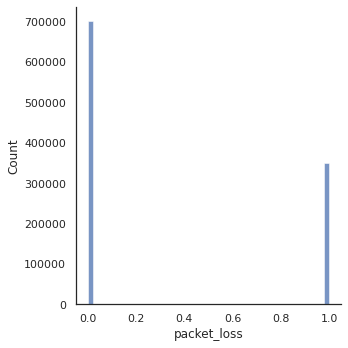

In [3]:
sns.set_theme(style="white")
sns.displot(pl, x="packet_loss")

### Check if issues are present with all source sites

In [ ]:
sns.catplot(y="src_site", x="packet_loss", data=pl)

### Preselect blocked source sites no matter how often it happens

In [3]:
selIPs = pl[pl['packet_loss']==1]['src'].unique()
selsites = pl[pl['packet_loss']==1]['src_site'].unique()
selhosts = pl[pl['packet_loss']==1]['src_host'].unique()
print(f"{len(selsites)} out of {len(pl[pl['packet_loss']>0.5]['src_site'].unique())} are showing 100% loss:")
print()
print(selsites)


17 out of 20 are showing 100% loss:

['UKI-SCOTGRID-ECDF' 'RO-03-UPB' 'FMPhI-UNIBA' 'UKI-NORTHGRID-LIV-HEP'
 'UKI-SCOTGRID-GLASGOW' 'UKI-SOUTHGRID-OX-HEP' 'RAL-LCG2' 'UKI-LT2-RHUL'
 'UKI-NORTHGRID-LANCS-HEP' 'CA-VICTORIA-WESTGRID-T2' 'CA-WATERLOO-T2'
 'GRIF' 'CA-SFU-T2' 'IN2P3-CPPM' 'SARA-MATRIX' 'praguelcg2' 'TRIUMF-LCG2']


### Check the mean pakcet loss for each source pair from the selected above

In [ ]:
avgLoss2infnRoma = pl[['src_site','packet_loss']].groupby(['src_site']).mean().round(decimals=3).reset_index().sort_values('packet_loss', ascending=False)

sns.catplot(y="src_site", x="packet_loss", data=avgLoss2infnRoma, kind="bar",
                height=10, aspect=.7)

#### 'CA-VICTORIA-WESTGRID-T2' is totally blocked

In [ ]:
pl[pl['src_site']=='CA-VICTORIA-WESTGRID-T2'][['src_site','src','packet_loss']]

#### remove CA-VICTORIA-WESTGRID-T2

In [12]:
# selIPs = list(selIPs)
# selIPs.remove('2607:f8f0:c10:70f3::60')

### Check if any of the source sites show issues with other destination sites than INFN-ROMA1

In [5]:
from model.DataLoader import GeneralDataLoader

meta = GeneralDataLoader()

dest_site = 'INFN-ROMA1'
destips = meta.pls[meta.pls['site'] == dest_site]['ip'].to_list()
print()
print(f'{dest_site} uses the following IPs for measuring packet loss {destips}')
print()


sdatalist = []
plossdict = {}
for src, dest in list(itertools.product(selIPs, destips)):
    data = qrs.getMeasures(dt, 'src', src, 'ps_packetloss', 'dest', dest)
    if data is not None:
        sdatalist.append(data)
        print(src, len(data))
        plossdict[data['src'].unique()[0]] = data

# plossdict

OBJECT EXISTS <class 'model.DataLoader.GeneralDataLoader'> 2021-02-01 12:00 2021-02-04 12:00

INFN-ROMA1 uses the following IPs for measuring packet loss ['141.108.35.18', '2001:760:422c:35::18']

2001:630:3c1:638::d546 23509
2001:b30:800:f0f0:141:85:240:231 21976
2001:4118:1a:2c00::ef:2 48367
2001:630:21:8d80::8afd:3c52 49835
2001:630:40:ef::7c 52920
2001:630:441:905::c 43022
2001:630:58:1820::82f6:b06d 28878
134.219.225.13 56924
2001:630:80:2fd::aaff:59f0 53601
2607:f8f0:c10:70f3::60 40
199.241.165.66 69
138.253.60.82 2822
2001:660:3031:110:ffff::221 59135
206.12.127.30 41290
2001:660:5408:1:134:158:20:192 42092
2001:610:108:203a::31 57577
2001:718:401:6025:1::192 15791
2607:f8f0:660:2::3 67457


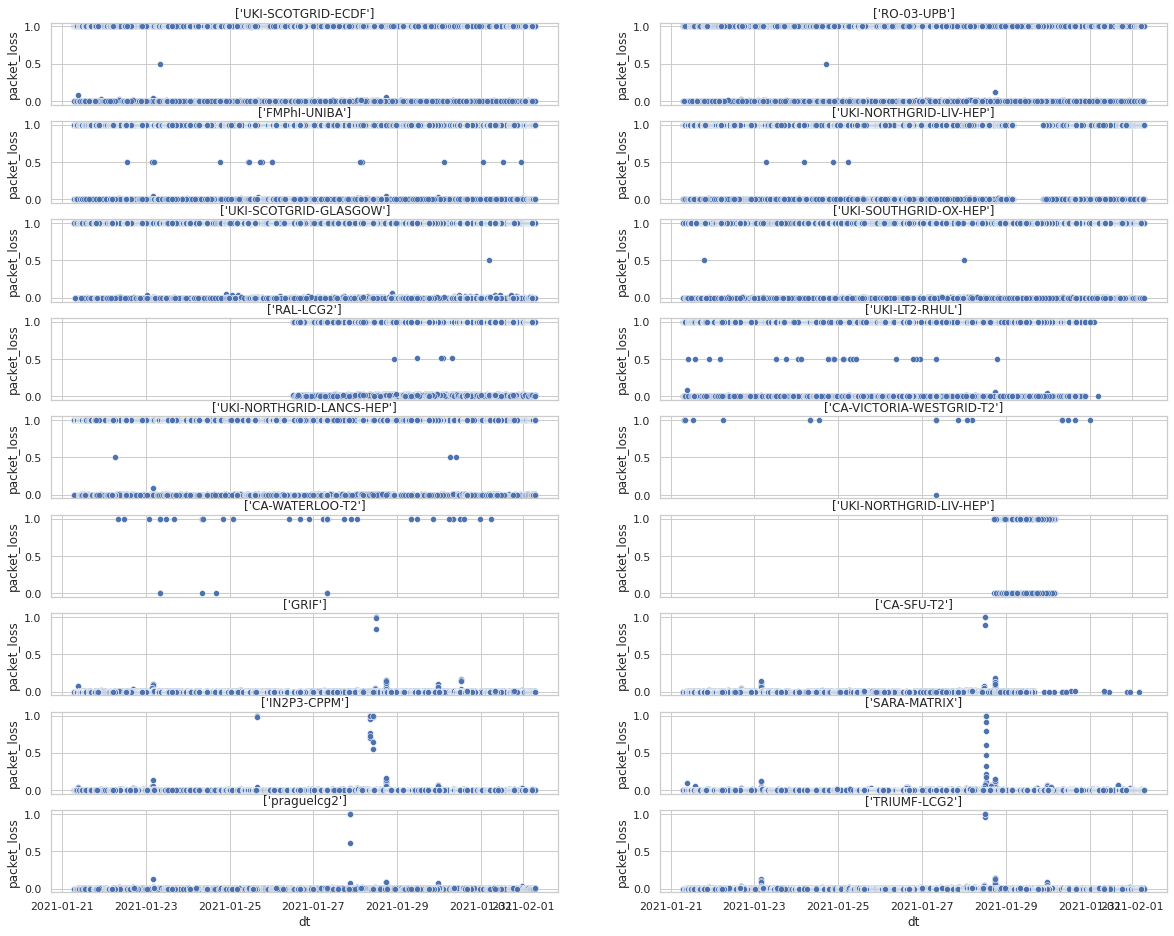

In [6]:
rows = int(np.ceil(len(sdatalist)/2))
fig, axes = plt.subplots(rows, 2, figsize=(20, 16), sharex=True)
i = 0
for r, c in list(itertools.product(range(0,rows), range(0,2))):
    if i < len(sdatalist):
        f = sns.scatterplot(ax=axes[r, c], data=sdatalist[i], y="packet_loss", x="dt").set_title(sdatalist[i]['src_site'].unique())
    i += 1

In [7]:
fig.savefig("selected_sources_measures.png")

### Check the distribution of packet loss values for each of the source sites.

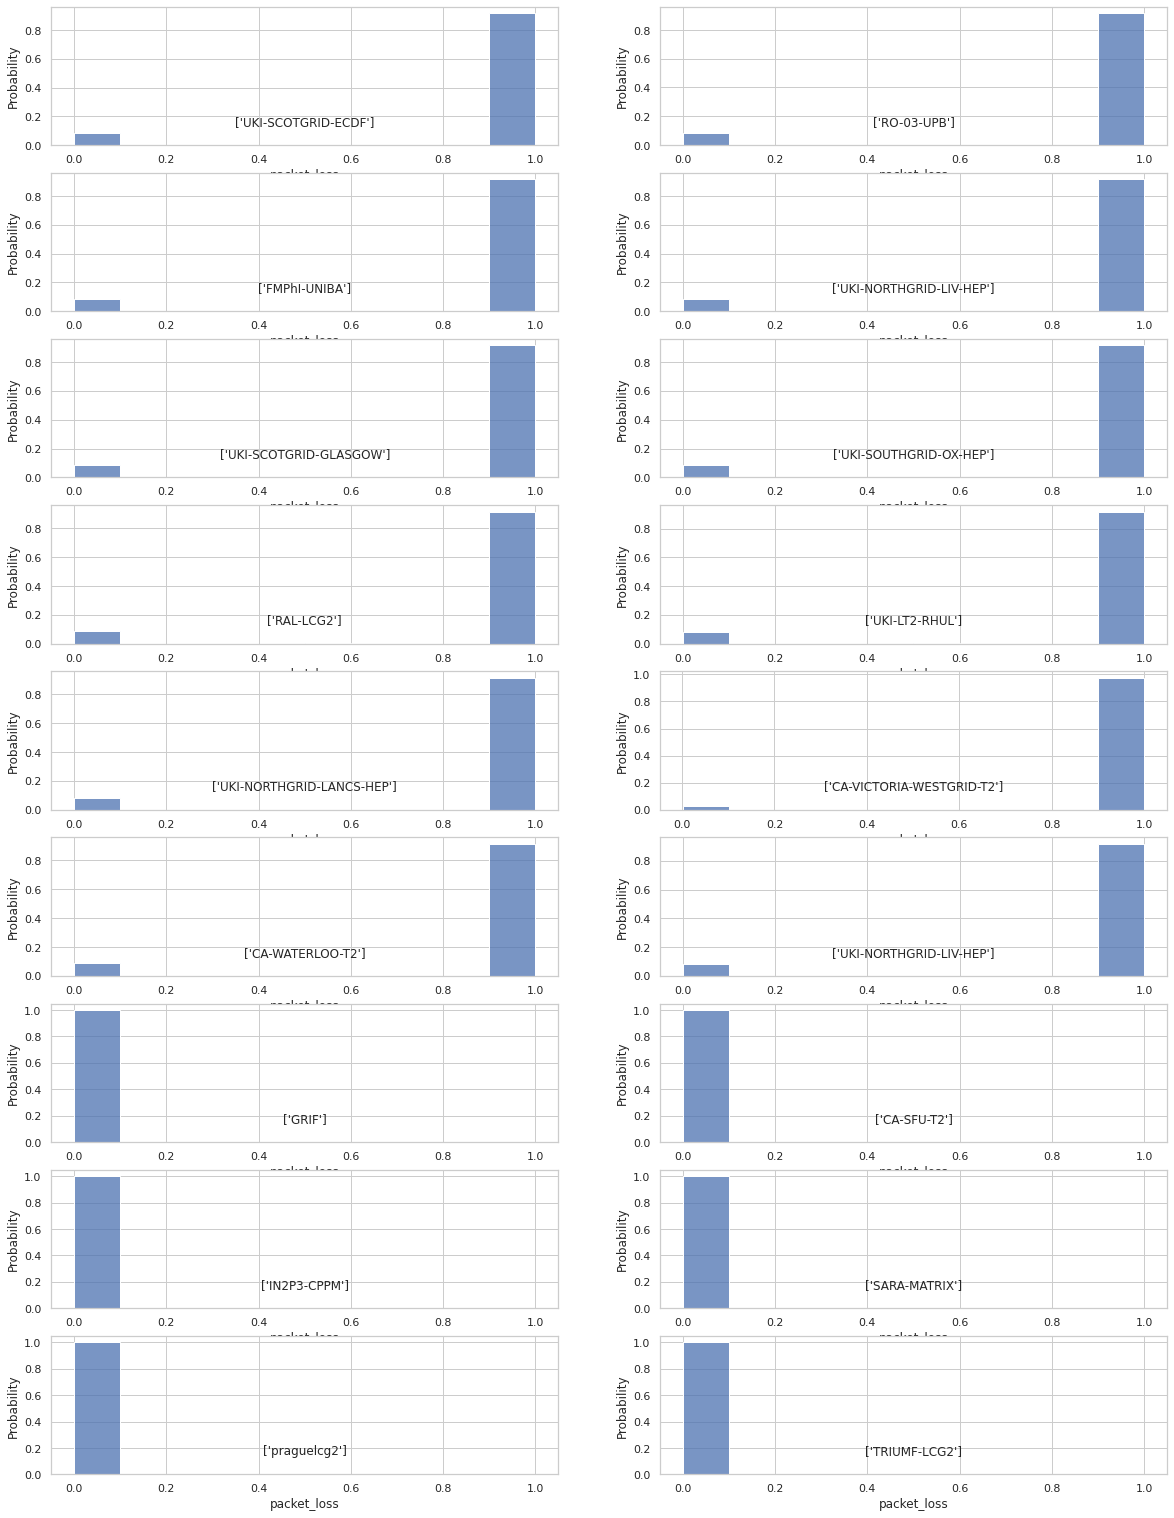

In [8]:
rows = int(np.ceil(len(sdatalist)/2))
f, axes = plt.subplots(rows, 2, figsize=(20, 27))
i = 0
for r, c in list(itertools.product(range(0,rows), range(0,2))):
    if i < len(sdatalist):
        sns.histplot(ax=axes[r, c], data=sdatalist[i], x="packet_loss",bins=10,stat='probability').set_title(sdatalist[i]['src_site'].unique(), y=0.1, fontsize = 12)
    i += 1

In [11]:
f.savefig("selected_sources_to_INFN-ROMA1.png")

In [9]:
#get all traceroute data for each of the IPs showing issues with INFN-ROMA1
tracedict, tracedflist = {}, []
for src, dest in list(itertools.product(selIPs, destips)):   
    data = qrs.getTraceroute('src', src, 'dest', dest, dt)
    if data is not None:
#         print(src, len(data))
        tracedict[src] = data
        tracedflist.append(data)
    else:  print('IP is not in ps_trace',src)
        

IP is not in ps_trace 2001:630:3c1:638::d546
IP is not in ps_trace 2001:b30:800:f0f0:141:85:240:231
IP is not in ps_trace 2001:4118:1a:2c00::ef:2
IP is not in ps_trace 2001:4118:1a:2c00::ef:2
IP is not in ps_trace 2001:630:21:8d80::8afd:3c52
IP is not in ps_trace 2001:630:40:ef::7c
IP is not in ps_trace 2001:630:441:905::c
IP is not in ps_trace 2001:630:58:1820::82f6:b06d
IP is not in ps_trace 134.219.225.13
IP is not in ps_trace 2001:630:80:2fd::aaff:59f0
IP is not in ps_trace 2607:f8f0:c10:70f3::60
IP is not in ps_trace 199.241.165.66
IP is not in ps_trace 138.253.60.82
IP is not in ps_trace 2001:660:3031:110:ffff::221
IP is not in ps_trace 206.12.127.30
IP is not in ps_trace 2001:660:5408:1:134:158:20:192
IP is not in ps_trace 2001:610:108:203a::31
IP is not in ps_trace 2001:718:401:6025:1::192
IP is not in ps_trace 2607:f8f0:660:2::3


### Calculate the mean packetloss for each path using the periods between traceroute measures

In [10]:
def calculatePathLoss(trace_df):

    # sort data before calculating
    trace_df = trace_df.sort_values('timestamp', ascending=True)
    # get the previous row value
    trace_df['dt_prev'] = trace_df.dt.shift(1)
    trace_df['route-sha1_prev'] = trace_df['route-sha1'].shift(1)
    
    src = trace_df['src'].unique()[0]
    dest = trace_df['dest'].unique()[0]
    
    # extract only the src-dest data
    loss = plossdict[src][plossdict[src]['dest']==dest]
    # loss['dt'] = loss['dt'].round('min')

    print(src, dest)


    def calcLoss(row):
#         print(row)
        ploss = loss[(loss['dt']<=row['dt']) & 
                     (loss['dt']>=row['dt_prev']) &
                     (loss['ipv6']==row['ipv6'])]['packet_loss'].mean()
        lossList = loss[(loss['dt']<=row['dt']) & 
                    (loss['dt']>=row['dt_prev']) &
                    (loss['ipv6']==row['ipv6'])]['packet_loss'].to_list()
        bl, zl = 0, 0
        if len(lossList)>0:
            cnt, total = 0, 0
            for i in lossList:
                if i <= 0.01:
                    cnt+=1
                total+=1
#             print('zeros:', cnt, ' out of ',  total, ' or ',  round(cnt/total,2)*100,'%')
            zl = round(cnt/total,2) if total>0 else 0

        if len(lossList)>0:
            cnt, total = 0, 0
            for i in lossList:
                if i > 0.1:
                    cnt+=1
                total+=1
#             print('big loss:', cnt, ' out of ', total, ' out of ',  round(cnt/total,2)*100,'%')
            bl = round(cnt/total,2) if total>0 else 0
#             print(f"period: {row['dt_prev']} to {row['dt']}    >10% loss: {bl}           <1% loss: {zl}")

        pathChanged = 1
        if row['route-sha1'] == row['route-sha1_prev']:
            pathChanged = 0

        return pd.Series([ploss, pathChanged, bl, zl])

    trace_df[['loss', 'path_changed', 'big_loss', 'zero_loss']] = trace_df.apply(calcLoss, axis=1)

    trace_df = trace_df[['push', 'MA', 'src', 'dest', 'src_host', 'dest_host', 'ipv6',
           'src_site', 'src_VO', 'dest_site', 'dest_VO', 'src_production',
           'dest_production', 'timestamp', 'hops', 'asns', 'rtts', 'ttls',
           'n_hops', 'max_rtt', 'destination_reached', 'route-sha1',
           'path_complete', 'looping', 'dt_prev', 'dt', 'route-sha1_prev', 'loss',
           'path_changed', 'big_loss', 'zero_loss']]

    return trace_df

i = 0
for df in tracedflist:
    tracedflist[i] = calculatePathLoss(df)
    i+=1

2001:630:3c1:638::d546 2001:760:422c:35::18
2001:b30:800:f0f0:141:85:240:231 2001:760:422c:35::18
2001:630:21:8d80::8afd:3c52 2001:760:422c:35::18
2001:630:40:ef::7c 2001:760:422c:35::18
2001:630:441:905::c 2001:760:422c:35::18
2001:630:58:1820::82f6:b06d 2001:760:422c:35::18
134.219.225.13 141.108.35.18
2001:630:80:2fd::aaff:59f0 2001:760:422c:35::18
2607:f8f0:c10:70f3::60 2001:760:422c:35::18
199.241.165.66 141.108.35.18
138.253.60.82 141.108.35.18
2001:660:3031:110:ffff::221 2001:760:422c:35::18
206.12.127.30 141.108.35.18
2001:660:5408:1:134:158:20:192 2001:760:422c:35::18
2001:610:108:203a::31 2001:760:422c:35::18
2001:718:401:6025:1::192 2001:760:422c:35::18
2607:f8f0:660:2::3 2001:760:422c:35::18


##### It seems there are too many measures for that period, let's see the average for one pair

Text(0.5, 1.0, "# of packetloss measures per hour for ['UKI-SCOTGRID-ECDF'] -> ['INFN-ROMA1']")

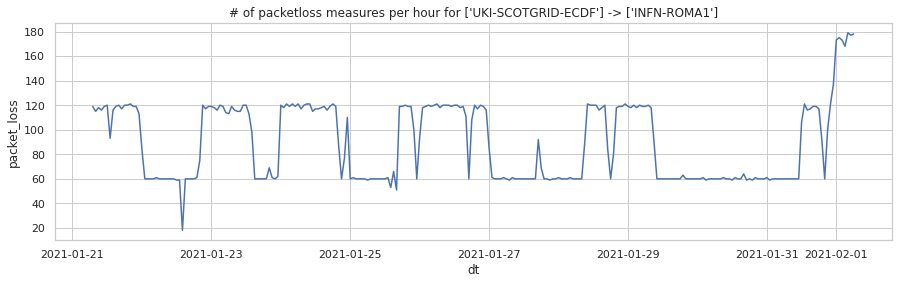

In [12]:
# g = df.groupby([pd.Grouper(key='dt',freq='H'), pd.Grouper('src'), pd.Grouper(key='dest')]).count().reset_index()
src, dest = '2001:630:3c1:638::d546', '2001:760:422c:35::18'

loss = plossdict[src][plossdict[src]['dest']==dest]
g = loss.groupby([pd.Grouper(key='dt',freq='H'), pd.Grouper('src'), pd.Grouper(key='dest')]).count().reset_index()
# g['push'].values
plt.figure(figsize=(15,4))
ax = sns.lineplot(data=g, x="dt", y="packet_loss")
ax.set_title(f"# of packetloss measures per hour for {loss['src_site'].unique()} -> {loss['dest_site'].unique()}")


##### Plot number of traceroute measures per hour

[Text(0, 0.5, '# of traceroute measures per hour')]

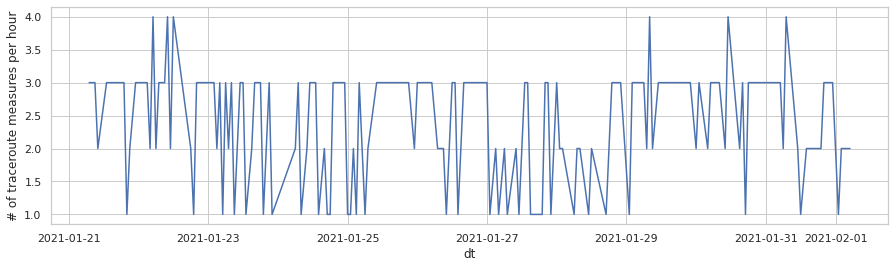

In [17]:
# g = df.groupby([pd.Grouper(key='dt',freq='H'), pd.Grouper('src'), pd.Grouper(key='dest')]).count().reset_index()
g = tracedflist[6].groupby([pd.Grouper(key='dt',freq='H'), pd.Grouper('src'), pd.Grouper(key='dest')]).count().reset_index()
# g['push'].values
plt.figure(figsize=(15,4))
ax = sns.lineplot(data=g, x="dt", y="push")
ax.set(ylabel='# of traceroute measures per hour')

##### Plot time between traceroute measures

[Text(0, 0.5, 'seconds between measures')]

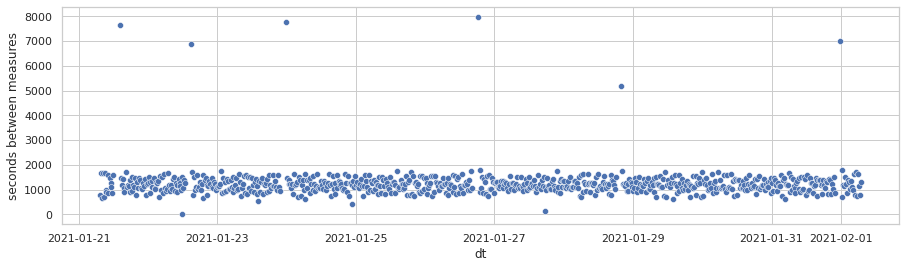

In [15]:
trace_df = tracedflist[0].sort_values('timestamp', ascending=True)

ser_diff = trace_df.dt.diff()
ser_diff.dt.seconds.div(60,fill_value=0)
trace_df['delta'] = ser_diff/ np.timedelta64(1, 's')

plt.figure(figsize=(15,4))
ax = sns.scatterplot(data=trace_df, x="dt", y="delta")
ax.set(ylabel='seconds between measures')

#### Merge all dataframes into one

In [18]:
mergedDf = pd.DataFrame()
for df in tracedflist:
    mergedDf = mergedDf.append(df)
    
mergedDf.reset_index(inplace=True)
# remove rows with null loss values
mergedDf = mergedDf[mergedDf['loss'].isnull() == False]
# remove rows when path is unknown
mergedDf = mergedDf[mergedDf['path_changed'] == 0]
mergedDf.reset_index(inplace=True)
print(len(mergedDf))

5027


##### Transform each hop into a column and True/False to indicate the presence of the hop

In [19]:
dfh = pd.get_dummies(mergedDf['hops'].apply(pd.Series).stack(), prefix='hop').sum(level=0)
hops = dfh.join(mergedDf[['route-sha1', 'destination_reached', 'path_complete', 'looping', 'loss', 'big_loss', 'zero_loss']])
hops[["destination_reached", "path_complete", "looping"]] = hops[["destination_reached", "path_complete", "looping"]].astype(int)

hops

,hop_134.219.225.1,hop_141.108.35.18,hop_145.100.0.157,hop_145.100.32.1,hop_146.97.33.1,hop_146.97.33.5,hop_146.97.35.217,hop_146.97.42.25,hop_172.16.208.10,hop_172.16.208.11,...,hop_90.147.80.6,hop_fd2a:62b:3c2c:cbc2:1:9:9:2,hop_fd2a:62b:3c2c:cbc2:4:ff:ff:f2,route-sha1,destination_reached,path_complete,looping,loss,big_loss,zero_loss
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,14ca8f29d5489868f468023e325963d7e281e161,1,0,0,0.846154,0.85,0.15
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,14ca8f29d5489868f468023e325963d7e281e161,1,0,0,0.946429,0.95,0.05
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,14ca8f29d5489868f468023e325963d7e281e161,1,0,0,0.909091,0.91,0.09
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,14ca8f29d5489868f468023e325963d7e281e161,1,0,0,1.000000,1.00,0.00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,14ca8f29d5489868f468023e325963d7e281e161,1,0,0,0.956522,0.96,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8cc8a139ce7b011fe3f4b4dbc19ee88b2a2c52fb,1,0,0,0.000443,0.00,1.00
5023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,15beb42b7256a16404fff985b7223726ea35a812,1,0,0,0.000029,0.00,1.00
5024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,15beb42b7256a16404fff985b7223726ea35a812,1,0,0,0.000062,0.00,1.00
5025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,15beb42b7256a16404fff985b7223726ea35a812,1,0,0,0.000604,0.00,1.00


#### Now let's find the mean loss based on a hop. This should highligh the most problematic hops 

In [20]:
# Example

print(hops.groupby('hop_145.100.0.157').agg({'loss': 'mean'}))

print(hops.groupby('hop_134.219.225.1').agg({'loss': 'mean'}))

                       loss
hop_145.100.0.157          
0                  0.667510
1                  0.000752
                       loss
hop_134.219.225.1          
0                  0.642517
1                  0.918731


In [21]:
hops.columns[:-7]

Index(['hop_134.219.225.1', 'hop_141.108.35.18', 'hop_145.100.0.157',
       'hop_145.100.32.1', 'hop_146.97.33.1', 'hop_146.97.33.5',
       'hop_146.97.35.217', 'hop_146.97.42.25', 'hop_172.16.208.10',
       'hop_172.16.208.11',
       ...
       'hop_62.40.98.187', 'hop_62.40.98.37', 'hop_62.40.98.81',
       'hop_66.97.16.230', 'hop_66.97.20.193', 'hop_90.147.80.10',
       'hop_90.147.80.18', 'hop_90.147.80.6', 'hop_fd2a:62b:3c2c:cbc2:1:9:9:2',
       'hop_fd2a:62b:3c2c:cbc2:4:ff:ff:f2'],
      dtype='object', length=144)

In [22]:
hopsdf = pd.DataFrame()
hopsDict = {}
for col in hops.columns[:-7]:
#     print(col)
    data = hops.groupby(col).agg({'loss': 'mean'}).to_dict()
    hopsDict[col] = data["loss"]
    if col == 'hop_2001:760:ffff:fffd::80:32':
        print(hops.groupby(col).agg({'loss': 'mean'}).to_dict())

# add everything to a dataframe
hopsdf = pd.DataFrame.from_dict({(i): hopsDict[i]
                           for i in hopsDict.keys()},
                       orient='index')

# hopsdf = hopsdf.T
hopsdf

,0,1,2
hop_134.219.225.1,0.642517,0.918731,NaN
hop_141.108.35.18,0.679864,0.572739,NaN
hop_145.100.0.157,0.667510,0.000752,NaN
hop_145.100.32.1,0.667510,0.000752,NaN
hop_146.97.33.1,0.642517,0.918731,NaN
...,...,...,...
hop_90.147.80.10,0.684440,0.000687,NaN
hop_90.147.80.18,0.640762,0.920752,NaN
hop_90.147.80.6,0.681375,0.000663,NaN
hop_fd2a:62b:3c2c:cbc2:1:9:9:2,0.623567,0.915210,NaN


#### Few hops can be categorised as really bad

In [23]:
hopsdf.sort_values(1, ascending=False)

,0,1,2
hop_62.40.124.241,0.664923,1.000000,NaN
hop_2001:798:99:1::55,0.664790,1.000000,NaN
hop_2607:f8f0:c10:70f3::1,0.664133,0.995483,NaN
hop_2607:f8f0:20:5::1,0.664133,0.995483,NaN
hop_2607:f8f0:c10:b7a::1,0.664133,0.995483,NaN
...,...,...,...
hop_2001:610:108:203a::2,0.665387,0.000127,NaN
hop_2001:610:108:203a::3,0.665387,0.000127,NaN
hop_2001:798:111:1::49,0.665387,0.000127,NaN
hop_2001:798:cc::1a,0.665387,0.000127,NaN


In [24]:
hopsdf = hopsdf.sort_values(1, ascending=True)

fig = go.Figure(data=go.Heatmap(
                   z=hopsdf.values,
                   x=hopsdf.columns,
                   y=hopsdf.index,
                   colorscale=px.colors.diverging.BrBG,
                   hoverongaps = False))

fig.update_layout(title=f'Mean packet loss for each hop',
                      template = 'plotly_white')


py.offline.plot(fig)

'temp-plot.html'

In [25]:
hopsdf[hopsdf[1]==1]

hopsdf.sort_values(1, ascending=False).head(20)

,0,1,2
hop_62.40.124.241,0.664923,1.000000,NaN
hop_2001:798:99:1::55,0.664790,1.000000,NaN
hop_2607:f8f0:c10:3::1,0.664133,0.995483,NaN
hop_2607:f8f0:c10:b7a::1,0.664133,0.995483,NaN
hop_2607:f8f0:c10:70f3::1,0.664133,0.995483,NaN
hop_2001:410:101:12::2,0.664133,0.995483,NaN
hop_2607:f8f0:20:5::1,0.664133,0.995483,NaN
hop_2001:410:101:11::1,0.664133,0.995483,NaN
hop_2001:798:29:10aa::1,0.664334,0.994127,NaN
hop_205.189.32.250,0.663495,0.952547,NaN


In [26]:
# routes = hops[(hops['hop_2001:798:99:1::55']==1) | (hops['hop_62.40.124.241']==1)]['route-sha1'].values

routes = []
for ip in hopsdf[(hopsdf[1]>0.95)].index:
    extracted = hops[(hops[ip]==1)]['route-sha1'].unique()
    for e in extracted:
        if e not in routes:
            routes.append(e)
# routes = hopsdf[(hopsdf[1]>0.98) & (hopsdf[1]<1)]['route-sha1'].values
routes

['f4f48c9df38acebae3d2fe9377b6c90a7499e7ce',
 'ce09269d99c5364e77551d71a7ad9293e1f97fe4',
 'e2329a2b6820e5249b4bb8db452c2f60894fca13',
 '4bbdb51321eddd4d86c2cd53bc8fa755351fe103',
 'c2bb1d752cca87493e98fc61b5aa02c54e0702db',
 '3b6cd21a9ec844e4c34e0df5a473b66b0cd46789']

In [31]:
mergedDf[(mergedDf['route-sha1'].isin(routes))][['src_host',
       'dest_host', 'src_site', 'destination_reached',
       'route-sha1', 'path_complete', 'looping', 'loss', 'big_loss', 'zero_loss']].sort_values('loss')

,src_host,dest_host,src_site,destination_reached,route-sha1,path_complete,looping,loss,big_loss,zero_loss
3626,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,0.000000,0.00,1.00
3622,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,0.857143,0.86,0.14
3633,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,0.909091,0.91,0.09
3612,ps-latency.hepnetcanada.ca,perfsonar2.roma1.infn.it,CA-VICTORIA-WESTGRID-T2,True,c2bb1d752cca87493e98fc61b5aa02c54e0702db,False,False,0.941275,0.94,0.06
3629,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,1.000000,1.00,0.00
3630,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,1.000000,1.00,0.00
3631,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,1.000000,1.00,0.00
3632,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,1.000000,1.00,0.00
3634,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,1.000000,1.00,0.00
3635,lcg-pslat.uw.computecanada.ca,perfsonar2.roma1.infn.it,CA-WATERLOO-T2,True,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,False,False,1.000000,1.00,0.00
